# roAp Classification using regression techniques:

### Updates:
* initial: (03/2/2023)
* linear regression: (04/4/2023)
* classification: (04/13/2023)
* polynomial regression classification: (04/18/22023)

In [11]:
from sklearn import neighbors, datasets, preprocessing, linear_model
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression, LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
from scipy.stats import gaussian_kde
from sklearn.preprocessing import PolynomialFeatures

%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

### 1. Importing csv files containing NGC 2264 and known roAps
        'roAp' is the csv file including the field roAps
        'clust' is the csv file including NGC 2264 cluster stars
        'all' is the concatenated of the two

In [2]:
r = pd.read_csv('Data/field_roAp.csv', index_col=False)
c = pd.read_csv('Data/15MON_A0_FOV.csv', index_col=False)
rfeat = r.columns
cfeat = c.columns

roAp = pd.DataFrame(r)
clust = pd.DataFrame(c)
dbr = np.append(np.array(roAp), np.array(roAp), axis=1)
dbc = np.append(np.array(clust), np.array(clust), axis=1)
# Concatenating datasets to find roAp condidates in NGC 2264
all = pd.concat([roAp, clust],axis=0)
all['designation'] = all['designation'].str.replace(r'\D', '')
db = np.append(np.array(all),np.array(all),axis=1)
# Extracting features of all datasets
yr = (roAp['GMAG0']).values
yc = (clust['GMAG0']).values
xr = (roAp['BP-RP0']).values
xc = (clust['BP-RP0']).values
y = (all['GMAG0']).values
x = (all['BP-RP0']).values

print('Features:', len(yr))
print('Target:', len(yc))
print('---------')
print('Total Dataset for field roAps:', dbr.data.shape)
print('Total Dataset for NGC 2264:', dbc.data.shape)
print('Concatenated Dataset:',all.shape)
all.describe()

Features: 93
Target: 965
---------
Total Dataset for field roAps: (93, 120)
Total Dataset for NGC 2264: (965, 172)
Concatenated Dataset: (1058, 90)


,num,id,ra,RA_ICRS,dec,DE_ICRS,GMAG0,BP-RP0,ecl_lon,ecl_lat,...,grvs_mag,grvs_mag_error,logg_gspphot,mh_gspphot,phot_bp_mean_flux,phot_bp_mean_flux_error,phot_g_mean_flux,phot_g_mean_flux_error,phot_rp_mean_flux,phot_rp_mean_flux_error
count,1058.000000,1058.000000,1058.000000,1058.000000,1058.000000,1058.000000,1058.000000,1058.000000,1058.000000,1058.000000,...,127.000000,127.000000,846.000000,846.000000,9.650000e+02,965.000000,9.650000e+02,965.000000,9.650000e+02,965.000000
mean,0.087902,528.500000,109.151299,109.151289,7.478114,7.478106,3.442366,0.757858,109.771502,-13.118243,...,12.503708,0.073577,4.376956,-1.251781,2.165922e+04,74.888334,4.196140e+04,21.822412,2.990228e+04,77.776609
std,0.283286,305.562596,41.211886,41.211825,13.838901,13.838930,2.109317,0.467252,42.045784,12.764718,...,1.210838,0.063511,0.459858,1.033316,1.807347e+05,1115.473325,3.672976e+05,110.827438,2.778614e+05,1033.807892
min,0.000000,0.000000,2.127157,2.127157,-81.902104,-81.902104,-2.724406,-0.274474,2.019759,-85.377605,...,7.257843,0.005903,1.560400,-4.080400,9.493662e+01,5.431366,7.524995e+02,1.351323,7.388467e+02,6.360226
25%,0.000000,264.250000,100.119403,100.119403,9.797506,9.797506,2.154758,0.536962,100.236203,-13.265848,...,12.066604,0.029815,4.194500,-1.636250,3.390643e+02,11.071645,1.269774e+03,2.042505,1.384733e+03,12.372756
50%,0.000000,528.500000,100.244704,100.244704,9.920538,9.920538,3.409107,0.713893,100.364398,-13.137302,...,12.808246,0.062369,4.455300,-1.098800,6.898837e+02,14.236284,2.602011e+03,2.892261,2.781346e+03,15.658791
75%,0.000000,792.750000,100.431403,100.431403,10.019111,10.019111,4.361791,0.921099,100.558289,-13.049704,...,13.332334,0.105035,4.713975,-0.429025,2.274583e+03,20.523827,7.898782e+03,6.651048,8.173050e+03,24.481014
max,1.000000,1057.000000,348.317184,348.305087,58.526905,58.526905,13.284124,3.569711,336.146049,69.335987,...,14.090522,0.507102,5.158000,0.635400,4.076147e+06,34367.074000,9.490580e+06,2162.942900,7.721012e+06,31803.912000


#### ~ Plotting the initial HRD with the field roAps and NGC 2264

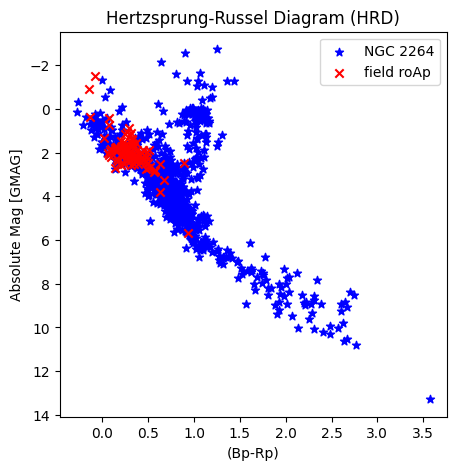

In [3]:
plt.figure(figsize=(5,5))
plt.scatter(x=xc,y=yc,marker='*', c='b', label='NGC 2264')
plt.scatter(x=xr,y=yr,marker='x', c='r', label='field roAp')
plt.legend()
plt.title('Hertzsprung-Russel Diagram (HRD)')
plt.ylabel('Absolute Mag [GMAG]')
plt.xlabel('(Bp-Rp)')
plt.gca().invert_yaxis()

----

### 2. Splitting the data to be used for training and showing the sizes

In [4]:
column = 0

# Splitting data 80:20

xtrain, xtest, ytrain, ytest = train_test_split(db[:,np.newaxis,8],
                                                db[:,7],train_size=0.8)

xtrain_r, xtest_r, ytrain_r, ytest_r = train_test_split(dbr[:,np.newaxis,8],
                                                        dbr[:,7],train_size=0.8)

xtrain_c, xtest_c, ytrain_c, ytest_c = train_test_split(dbc[:,np.newaxis,8],
                                                        dbc[:,7],train_size=0.8)

scalar = preprocessing.StandardScaler().fit(xtrain)
xtrain = scalar.transform(xtrain)
xtest = scalar.transform(xtest)

print(f"roAp->\nTrain: {xtrain_r.shape}, Label: {ytrain_r.shape}")
print(f"Test: {xtest_r.shape}, Label: {ytest_r.shape}")
print('-----------------')
print(f"cluster->\nTrain: {xtrain_c.shape}, Label: {ytrain_c.shape}")
print(f"Test: {xtest_c.shape}, Label: {ytest_c.shape}")
print('-----------------')
print(f"Concat->\nTrain: {xtrain.shape}, Label: {ytrain.shape}")
print(f"Test: {xtest.shape}, Label: {ytest.shape}")

roAp->
Train: (74, 1), Label: (74,)
Test: (19, 1), Label: (19,)
-----------------
cluster->
Train: (772, 1), Label: (772,)
Test: (193, 1), Label: (193,)
-----------------
Concat->
Train: (846, 1), Label: (846,)
Test: (212, 1), Label: (212,)


----

### 3. Training the Linear Regression model and plotting with the HRD

Coefficient for roAp or slope(m) in y = mx+b: [3.42982626]
Coefficient for cluster or slope(m) in y = mx+b: [3.11427054]

Mean squared error for roAp: 0.37
Mean squared error for cluster: 2.18

Coefficient of determination for roAp: 0.26
Coefficient of determination for cluster: 0.56


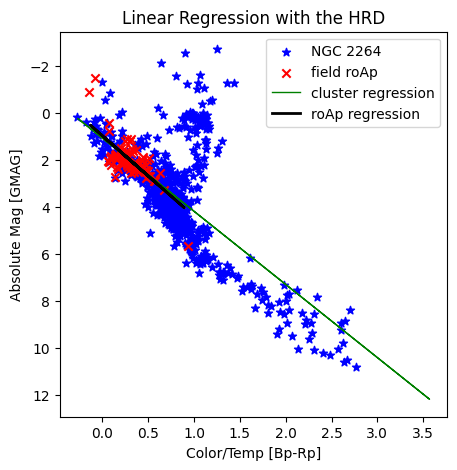

In [5]:
regr = LinearRegression()
regc = LinearRegression()
# Fitting/Training the model
regr.fit(xtrain_r,ytrain_r)
regc.fit(xtrain_c,ytrain_c)
# Predictions
data_r_pred = regr.predict(xtest_r)
data_c_pred = regc.predict(xtest_c)

# The coefficients
print(f"Coefficient for roAp or slope(m) in y = mx+b: {regr.coef_}")
print(f"Coefficient for cluster or slope(m) in y = mx+b: {regc.coef_}")
# The mean squared error
print("\nMean squared error for roAp: %.2f" % mean_squared_error(ytest_r, data_r_pred ))
print("Mean squared error for cluster: %.2f" % mean_squared_error(ytest_c, data_c_pred ))
# The coefficient of determination: 1 is perfect prediction
print("\nCoefficient of determination for roAp: %.2f" % r2_score(ytest_r, data_r_pred ))
print("Coefficient of determination for cluster: %.2f" % r2_score(ytest_c, data_c_pred ))

plt.figure(figsize=(5,5))
plt.title('Linear Regression with the HRD')
plt.scatter(x=xtrain_c,y=ytrain_c,marker='*', c='b', label='NGC 2264')
plt.scatter(x=xtrain_r,y=ytrain_r,marker='x', c='r', label='field roAp')
plt.gca().invert_yaxis()
plt.plot(xtest_c,data_c_pred,c='green',linewidth=1,label='cluster regression')
plt.plot(xtest_r,data_r_pred,c='black',linewidth=2,label='roAp regression')
plt.legend()
plt.ylabel('Absolute Mag [GMAG]')
plt.xlabel('Color/Temp [Bp-Rp]')
plt.savefig('Figures/LinearRegHRD-both')

----

### 4. Training and plotting the concatenated dataset with the linear regression

#### ~ The following shows the FOV we want with the current data:

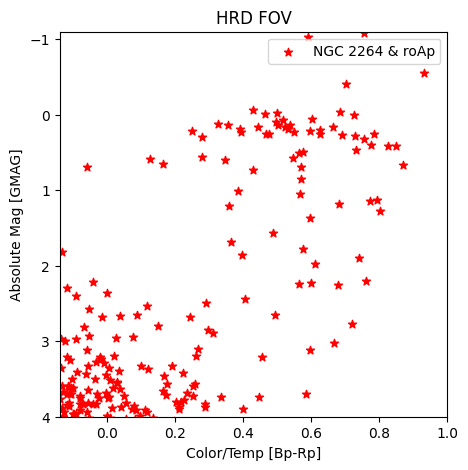

In [6]:
plt.figure(figsize=(5,5))
plt.title('HRD FOV')
plt.ylim([-1.1,4])
plt.xlim([-0.14,1])
plt.scatter(xtrain,ytrain,marker='*',c='r',label='NGC 2264 & roAp')
plt.gca().invert_yaxis()
plt.legend()
plt.ylabel('Absolute Mag [GMAG]')
plt.xlabel('Color/Temp [Bp-Rp]')
plt.savefig('Figures/LinearRegHRD-concat.png')

#### ~ Fitting the roAp's regression to the concatenated dataset and finding the deviations:

In [35]:
# For field roAp's
regr.fit(xtrain_r,ytrain_r)
pred = regr.predict(xtrain)
predr = regr.predict(xtrain_r)
print("Regression Coefficient:", regr.coef_[0])
dist = np.abs(ytrain - pred)
print('Length of the deviation list:', len(dist))

Regression Coefficient: 3.4298262601949143
Length of the deviation list: 846


#### ~ Computing which cluster stars are potential candidates using the deviations, threshold value, and the maximum B-R value:

In [33]:
print('Stars in NGC 2264 following the Linear regression:')
cands = []
thresh = 1.5
max = (xr.max()) + 0.5
for n in range(len(ytrain)):
    if (dist[n]<thresh) & (xtrain[n]<max):
        cand = clust.iloc[n]['id']
        print('Deviation:', dist[n],'| ID:',cand, '| GMAG:', ytrain[n], '| B-R: ', xtrain[n][0])
        cands.append({'ID':cand,'Deviation':dist[n],'GMAG':ytrain[n],'B-R':xtrain[n][0]})

Stars in NGC 2264 following the Linear regression:
Deviation: 1.427909618772551 | ID: 99 | GMAG: 1.049143 | B-R:  0.5656170197492463
Deviation: 1.2874420673782874 | ID: 116 | GMAG: 6.310009 | B-R:  0.8819340516692581
Deviation: 1.476558260556378 | ID: 156 | GMAG: 3.334671 | B-R:  0.1902693056380791
Deviation: 0.7648777129627162 | ID: 188 | GMAG: 2.847243 | B-R:  0.29735388152267567
Deviation: 1.0928690929109772 | ID: 189 | GMAG: 2.803017 | B-R:  0.1480585451619229
Deviation: 0.7324009761686312 | ID: 193 | GMAG: 1.570124 | B-R:  0.4863609217461755
Deviation: 0.710743468627673 | ID: 194 | GMAG: 2.250628 | B-R:  0.6780957457985496
Deviation: 1.1627103627267952 | ID: 205 | GMAG: 1.01595 | B-R:  0.383594630975767
Deviation: 1.017334986137292 | ID: 235 | GMAG: 0.590921 | B-R:  0.12457164868504889
Deviation: 0.4281636862190208 | ID: 258 | GMAG: 2.499198 | B-R:  0.2893674895827036
Deviation: 0.3648748079348101 | ID: 264 | GMAG: 2.223185 | B-R:  0.5994877082392952
Deviation: 0.692865189565379 |

### 5. Exporting potential candidates

#### ~ Writing the data to a csv file:

In [34]:
print(len(cands))
df = pd.DataFrame(cands)
df.to_csv('Data/linear-candidates.csv',index=False,header=True)

df.describe()

42


,ID,Deviation,GMAG,B-R
count,42.000000,42.000000,42.000000,42.000000
mean,550.452381,0.852672,2.586517,0.441670
std,274.942673,0.409274,1.630519,0.269139
min,99.000000,0.126244,-2.148273,-0.249194
25%,266.000000,0.490575,1.710888,0.261698
50%,541.500000,0.866113,2.594673,0.436421
75%,811.250000,1.172673,3.178963,0.598968
max,927.000000,1.496361,6.551831,0.957018


#### ~ Displaying the candidates with the roAp's:

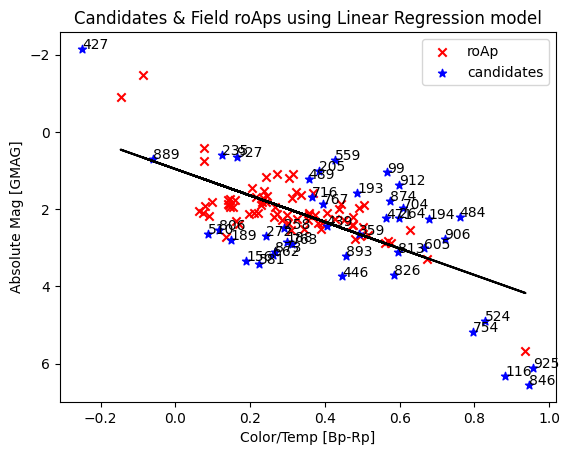

In [37]:
a = df['B-R']
b = df['GMAG']

plt.gca().invert_yaxis()
plt.title('Candidates & Field roAps using Linear Regression model')
plt.scatter(xtrain_r,ytrain_r,marker='x',c='r',label='roAp')
plt.scatter(a,b,marker='*',c='b',label='candidates')
plt.plot(xtrain_r,predr,c='black')
plt.ylabel('Absolute Mag [GMAG]')
plt.xlabel('Color/Temp [Bp-Rp]')
plt.legend()

for i, id in enumerate(df['ID']):
    plt.annotate(id, (a[i],b[i]))
plt.savefig('Figures/Linear-Candidates')
plt.show()

### 6. Showing which degree is best to fit to data for no under/over fitting

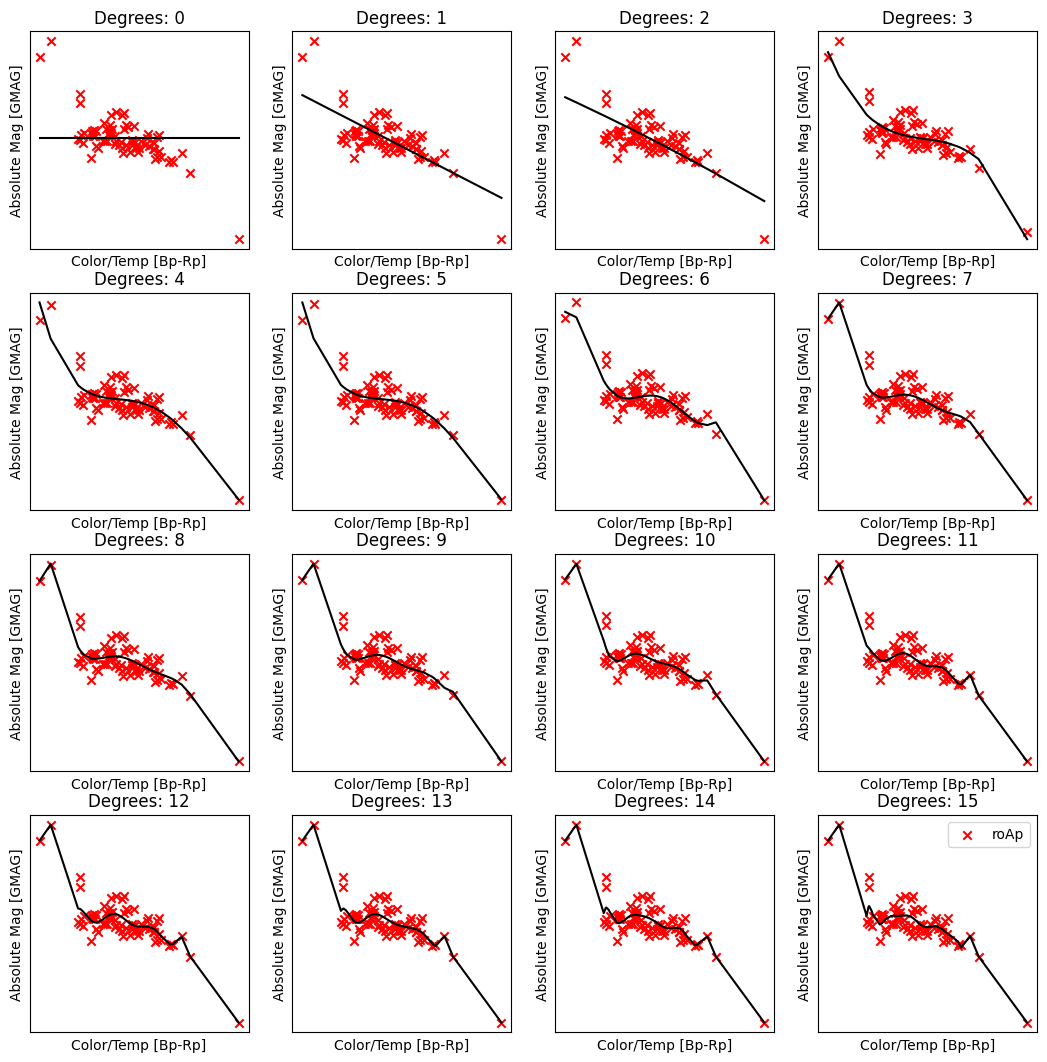

In [177]:
# Flattening the series for the x-values and prediction values
xf = pd.Series(xtrain_r.flatten())
# Sorting
xs = xf.sort_values()
# Arraning into an array to plot
xarr = np.array(xs)

plt.figure(figsize=(13,13))
for i in range(16):
    plt.subplot(4,4,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)

    polyi = PolynomialFeatures(degree=(i))

    pfri = polyi.fit_transform(xtrain_r)
    pfi = polyi.fit_transform(xtrain)
    regpi = LinearRegression()
    regpi.fit(pfri, ytrain_r)

    yfi = pd.Series(regpi.predict(pfri).flatten())
    ypredi = np.array(yfi[xs.index])

    plt.gca().invert_yaxis()
    plt.title(f'Degrees: {i}')
    plt.scatter(xtrain_r,ytrain_r,marker='x',c='r',label='roAp')
    plt.plot(xarr,ypredi,c='black')
    plt.ylabel('Absolute Mag [GMAG]')
    plt.xlabel('Color/Temp [Bp-Rp]')
    plt.savefig('Figures/ith-deg-Polynomial-roAp')
plt.legend()

### 7. Training and plottting the concatenated dataset using polynomial regression
        5 degrees being used, chosen from subplot

In [178]:
deg = 5
poly = PolynomialFeatures(degree=deg, include_bias=False)
pfr = poly.fit_transform(xtrain_r)
pf = poly.fit_transform(xtrain)
regp = LinearRegression()
regp.fit(pfr, ytrain_r)
print('')

#### ~ Predicting, calculating deviation, and exporting candidates then plotting

In [179]:
predp = regp.predict(pf)
predpr = regp.predict(pfr)
print(f'Intercept: {regp.intercept_} and Coefficient: {regp.coef_}')
print('The Mean Squared Error: %.2f' % mean_squared_error(ytrain,pred))
dist = np.abs(ytrain - predp)
print('Length of the deviation list:', len(dist))

Intercept: 0.9464231972719241 and Coefficient: [ 10.22424746 -37.80227413  57.62599501 -21.28132214  -3.73956406]
The Mean Squared Error: 12.09
Length of the deviation list: 846


In [180]:
print('Stars in NGC 2264 following the Polynomial regression:')
cands = []
thresh = 1.5
max = (xr.max()) + 0.5
for n in range(len(ytrain)):
    if (dist[n]<thresh) & (xtrain[n]<max):
        cand = clust.iloc[n]['id']
        print('Deviation:', dist[n],'| ID:',cand, '| GMAG:', ytrain[n], '| B-R: ', xtrain[n][0])
        cands.append({'ID':cand,'Deviation':dist[n],'GMAG':ytrain[n],'B-R':xtrain[n][0]})

Stars in NGC 2264 following the Polynomial regression:
Deviation: 1.0895218260678394 | ID: 116 | GMAG: 6.310009 | B-R:  0.8819340516692581
Deviation: 1.443305064505706 | ID: 156 | GMAG: 3.334671 | B-R:  0.1902693056380791
Deviation: 0.3525624796735096 | ID: 179 | GMAG: 6.416677 | B-R:  1.067429705566459
Deviation: 0.8630292808036493 | ID: 188 | GMAG: 2.847243 | B-R:  0.29735388152267567
Deviation: 0.9949422536789956 | ID: 189 | GMAG: 2.803017 | B-R:  0.1480585451619229
Deviation: 0.7441163849867853 | ID: 193 | GMAG: 1.570124 | B-R:  0.4863609217461755
Deviation: 1.1788429624236922 | ID: 194 | GMAG: 2.250628 | B-R:  0.6780957457985496
Deviation: 1.0508365175131058 | ID: 205 | GMAG: 1.01595 | B-R:  0.383594630975767
Deviation: 1.378905515978116 | ID: 216 | GMAG: 2.661548 | B-R:  0.03789038755772948
Deviation: 1.1486949521264174 | ID: 235 | GMAG: 0.590921 | B-R:  0.12457164868504889
Deviation: 0.5200608890909859 | ID: 258 | GMAG: 2.499198 | B-R:  0.2893674895827036
Deviation: 0.6441172469

In [181]:
print(len(cands))
dfp = pd.DataFrame(cands)
dfp.to_csv('Data/polynomial-candidates.csv',index=False,header=True)

dfp.describe()

52


,ID,Deviation,GMAG,B-R
count,52.000000,52.000000,52.000000,52.000000
mean,557.557692,0.909481,3.250317,0.506884
std,263.595309,0.395375,1.942947,0.321282
min,116.000000,0.133598,0.554031,-0.059641
25%,271.750000,0.613103,1.950165,0.264783
50%,570.000000,0.950523,2.787344,0.471088
75%,807.750000,1.183668,4.873287,0.738504
max,927.000000,1.492180,7.064132,1.110708


#### ~ Displaying graph of roAp candidates with field roAp's using 5 degree polynomial regression

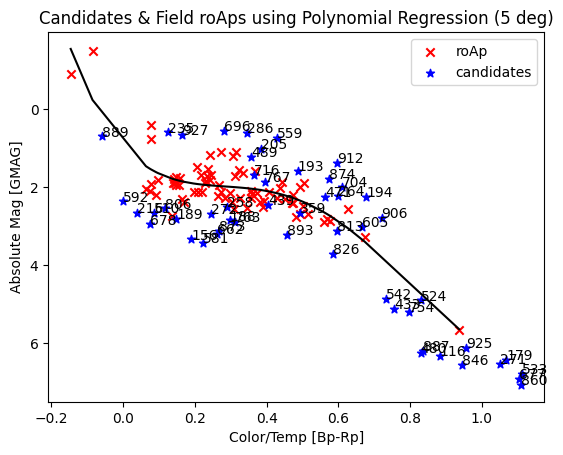

In [183]:
a = dfp['B-R']
b = dfp['GMAG']
# Flattening the series for the x-values and prediction values
xf = pd.Series(xtrain_r.flatten())
yf = pd.Series(predpr.flatten())
# Sorting
xs = xf.sort_values()
# Arraning into an array to plot
ypred = np.array(yf[xs.index])
xarr = np.array(xs)

plt.gca().invert_yaxis()
plt.title(f'Candidates & Field roAps using Polynomial Regression ({deg} deg)')
plt.scatter(xtrain_r,ytrain_r,marker='x',c='r',label='roAp')
plt.scatter(a,b,marker='*',c='b',label='candidates')
plt.plot(xarr,ypred,c='black')
plt.ylabel('Absolute Mag [GMAG]')
plt.xlabel('Color/Temp [Bp-Rp]')
plt.legend()

for i, id in enumerate(dfp['ID']):
    plt.annotate(id, (a[i],b[i]))
plt.savefig('Figures/Polynomial-Candidates-10deg')
plt.show()